In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import wandb
import Neural_Lib_Flo as nlb
import wandb_library as wl 
import training_lib as tl
import torch.nn.functional as F
# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir_sensorium = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'
sub_responses_path= '/project/subiculum/data/Post_Sub_Data.mat'

sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)


: 

# Predicting neural activity in V1 and Postsub
This notebook is the full training of models on neural data recorded in anesthetized mice that were shown natural images. The goal is to adequately well predict the activity with a correlation close to that of the model's performance on the data from the Sensorium competition which will be used as a benchmark.

## July 5th, 2024

I have already run a sweep using wandb, so this won't be done again here.

First, we will train the model on V1, Postsub and Sensorium (also V1) data to get a rough estimate of the basic model's perfromance.

In [2]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
v1_model=nlb.configure_model(config, 13, device)
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)
tl.training_and_eval_with_lr(v1_model, config.get("epochs"), v1_train_loader, v1_test_loader, v1_val_loader, device, save_model=True, path_for_saving='models/v1_model.pt')

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/50], validation correlation: 0.0172, trainloss: 0.4102
Epoch [2/50], validation correlation: 0.0196, trainloss: 0.2886
Epoch [3/50], validation correlation: 0.0494, trainloss: 0.3525
Epoch [4/50], validation correlation: 0.0543, trainloss: 0.3110
Epoch [5/50], validation correlation: 0.0397, trainloss: 0.3696
Epoch [6/50], validation correlation: 0.0501, trainloss: 0.3615
Epoch [7/50], validation correlation: 0.0563, trainloss: 0.2796
Epoch [8/50], validation correlation: 0.0484, trainloss: 0.2755
Epoch [9/50], validation correlation: 0.0488, trainloss: 0.3153
Epoch [10/50], validation correlation: 0.0608, trainloss: 0.3378
Epoch [11/50], validation correlation: 0.0572, trainloss: 0.2615
Epoch [12/50], validation correlation: 0.0661, trainloss: 0.3212
Epoch [13/50], validation correlation: 0.0518, trainloss: 0.3041
Epoch [14/50], validation correlation: 0.0621, trainloss: 0.3227
Epoch [15/50], validation correlation: 0.0602, trainloss: 0.3207
Epoch [16/50], validation correlat

We can now use the same configuration to get a rough idea of what training with the Sub Data would give:

In [3]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
sub_run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
sub_config=sub_run.config
sub_model=nlb.configure_model(sub_config, 37, device)
tl.training_and_eval_with_lr(sub_model, config.get("epochs"),sub_train_loader, sub_val_loader, sub_test_loader, device, save_model=True, path_for_saving='models/sub_model.pt'), 

Epoch [1/50], validation correlation: 0.0218, trainloss: 0.3488
Epoch [2/50], validation correlation: 0.0359, trainloss: 0.5190
Epoch [3/50], validation correlation: 0.0558, trainloss: 0.4626
Epoch [4/50], validation correlation: 0.0504, trainloss: 0.4023
Epoch [5/50], validation correlation: 0.0524, trainloss: 0.4529
Epoch [6/50], validation correlation: 0.0532, trainloss: 0.4435
Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch [7/50], validation correlation: 0.0483, trainloss: 0.3873
Epoch [8/50], validation correlation: 0.0531, trainloss: 0.4015
Early stopping triggered!

model saved as models/sub_model.pt
Test Loss: 0.4425
Test Correlation: 0.0672


(None,)

In [4]:
sensorium_train_loader, sensorium_val_loader, sensorium_test_loader = nlb.dataloader_from_npy_pretraining(root_dir_sensorium, device)
sensorium_model = nlb.ConvModel(layers=5, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372).to(device)
tl.training_and_eval_with_lr(sensorium_model, 100, sensorium_train_loader, sensorium_test_loader, sensorium_val_loader, device,gamma=1e-2,lr=1e-3, save_model=True, path_for_saving=("models/sens_model.pt"))


Epoch [1/100], validation correlation: 0.0482, trainloss: 0.8465
Epoch [2/100], validation correlation: 0.0522, trainloss: 0.6999
Epoch [3/100], validation correlation: 0.0567, trainloss: 0.6703
Epoch [4/100], validation correlation: 0.0605, trainloss: 0.6755



KeyboardInterrupt: 

We can also train the model on the OFF response for both postsub and V1.

In [5]:
v1_run_or = api.run("seifertflo/V1 OFF response Training 24-06-2024/tgly5e97")
v1_train_loader_or, v1_val_loader_or, v1_test_loader_or = nlb.dataloader_from_mat(images_path, v1_responses_path, time_begin=125, time_end=200, batch_size=64)
v1_or_config=v1_run_or.config
v1_or_model=nlb.configure_model(v1_or_config, 13, device)
tl.training_and_eval_with_lr(v1_or_model,100, v1_val_loader_or,v1_train_loader_or, v1_test_loader_or,device,True,0.08865963714161047,path_for_saving="/project/subiculum/code/models/v1_model_or.pt", early_stopping=False)

Epoch [1/100], validation correlation: -0.0224, trainloss: -0.1282
Epoch [2/100], validation correlation: -0.0601, trainloss: -0.1810
Epoch [3/100], validation correlation: -0.0141, trainloss: -0.1888
Epoch [4/100], validation correlation: 0.0631, trainloss: -0.1907
Epoch [5/100], validation correlation: 0.0568, trainloss: -0.2387
Epoch [6/100], validation correlation: 0.0965, trainloss: -0.2787
Epoch [7/100], validation correlation: 0.0991, trainloss: -0.2783
Epoch [8/100], validation correlation: 0.1027, trainloss: -0.1930
Epoch [9/100], validation correlation: 0.1072, trainloss: -0.2525
Epoch [10/100], validation correlation: 0.1146, trainloss: -0.2683
Epoch [11/100], validation correlation: 0.1096, trainloss: -0.2593
Epoch [12/100], validation correlation: 0.1130, trainloss: -0.2487
Epoch [13/100], validation correlation: 0.1038, trainloss: -0.2590
Epoch    14: reducing learning rate of group 0 to 8.8660e-03.
Epoch [14/100], validation correlation: 0.1046, trainloss: -0.2600
Epoch 

In [6]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
sub_or_run = api.run("seifertflo/Sub OFF response Training 24-06-2024/bp5jezif")
sub_config_or=sub_or_run.config
sub_model_or=nlb.configure_model(sub_config_or, 37, device).to(device)
tl.training_and_eval_with_lr(sub_model_or, 100,sub_train_loader_or, sub_val_loader_or, sub_test_loader_or, device, save_model=True, path_for_saving='models/sub_model_or.pt', early_stopping=False), 

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: 0.0018, trainloss: -0.0480
Epoch [2/100], validation correlation: 0.0136, trainloss: 0.1464
Epoch [3/100], validation correlation: 0.0387, trainloss: 0.2303


Epoch [4/100], validation correlation: 0.0232, trainloss: 0.1624
Epoch [5/100], validation correlation: 0.0418, trainloss: -0.4695
Epoch [6/100], validation correlation: 0.0388, trainloss: -0.0837
Epoch [7/100], validation correlation: 0.0410, trainloss: -0.3248
Epoch [8/100], validation correlation: 0.0554, trainloss: -0.0969
Epoch [9/100], validation correlation: 0.0532, trainloss: -0.1119
Epoch [10/100], validation correlation: 0.0648, trainloss: -0.1890
Epoch [11/100], validation correlation: 0.0619, trainloss: 0.1365
Epoch [12/100], validation correlation: 0.0665, trainloss: -0.0453
Epoch [13/100], validation correlation: 0.0649, trainloss: -0.1735
Epoch [14/100], validation correlation: 0.0727, trainloss: -0.0405
Epoch [15/100], validation correlation: 0.0560, trainloss: 0.1954
Epoch [16/100], validation correlation: 0.0604, trainloss: -0.0540
Epoch [17/100], validation correlation: 0.0672, trainloss: 0.0972
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
Epoch [18/

(None,)

As one gets a correlation of ~30% for the Sensorium data, it would be helpful to understand why this is not reached for the v1 data here. 

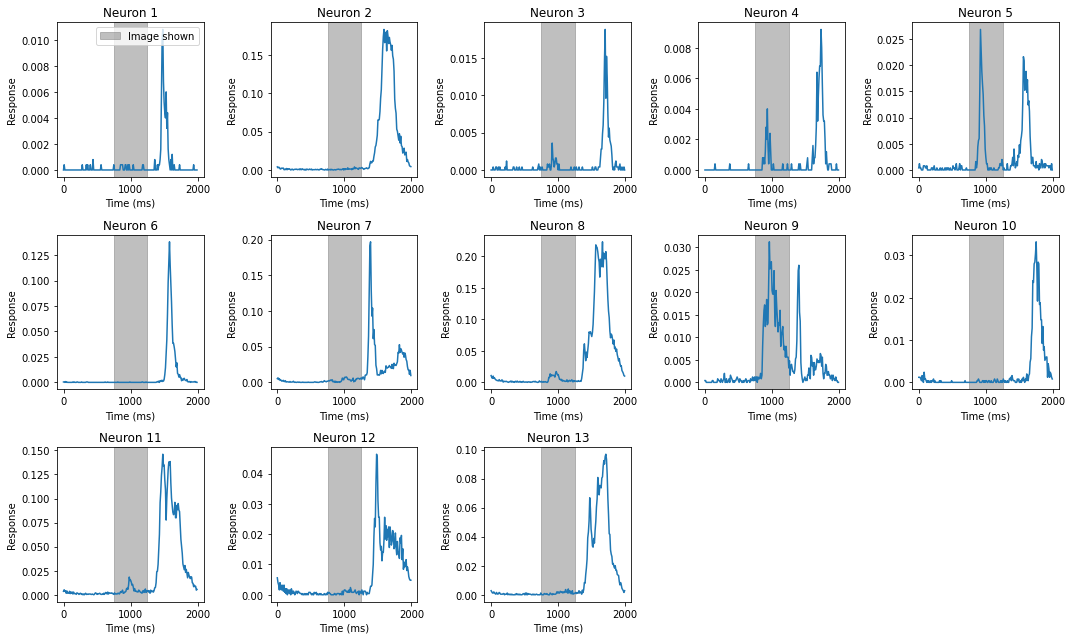

In [7]:
nlb.plot_avrg_response(images_path, v1_responses_path)

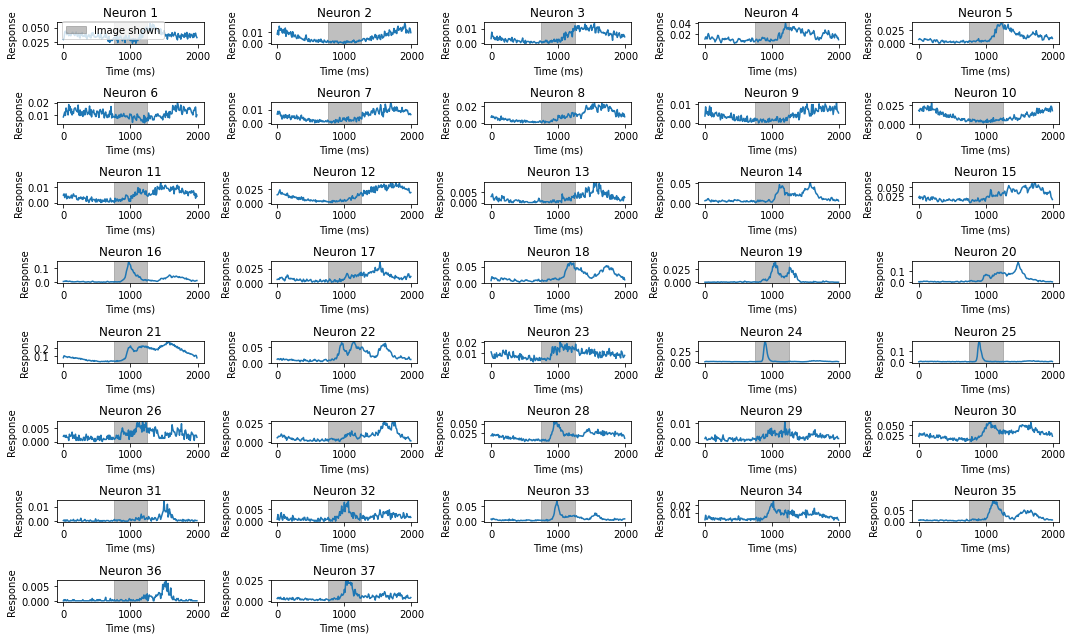

In [8]:
nlb.plot_avrg_response(images_path, sub_responses_path)

## Spike triggered averages

Shows the STA for the best neurons (in terms of correlation on the validation loader):
torch.Size([5994])
Processing neuron 4741...
Processing neuron 6430...
Processing neuron 831...
Processing neuron 6694...
Processing neuron 611...
Processing neuron 6699...
Processing neuron 3992...
Processing neuron 5604...
Processing neuron 7310...
Processing neuron 1440...
Processing neuron 6371...
Processing neuron 1872...


/project/subiculum/code/Neural_Lib_Flo.py:965: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


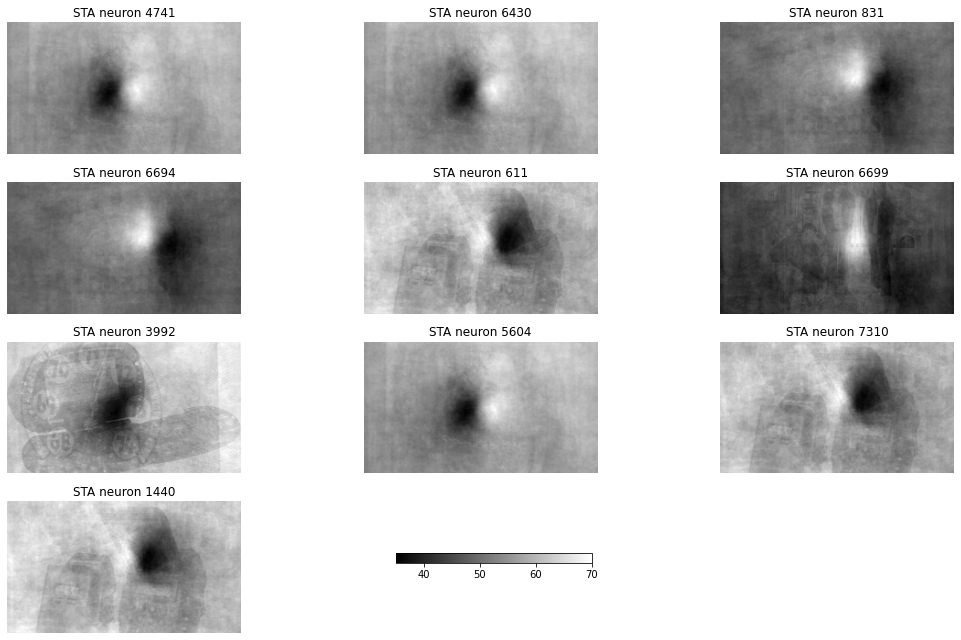

In [9]:
state_dict_sens = torch.load('models/sens_model.pt')
sensorium_model.load_state_dict(state_dict_sens)
sensorium_model.to(device)
with torch.no_grad():
    sens_val_corrs = nlb.get_correlations(sensorium_model, sensorium_val_loader, device)
best_neurons_sens = np.argsort(-sens_val_corrs)
nlb.sta_wo_model(device,best_neurons_sens, root_dir_sensorium)

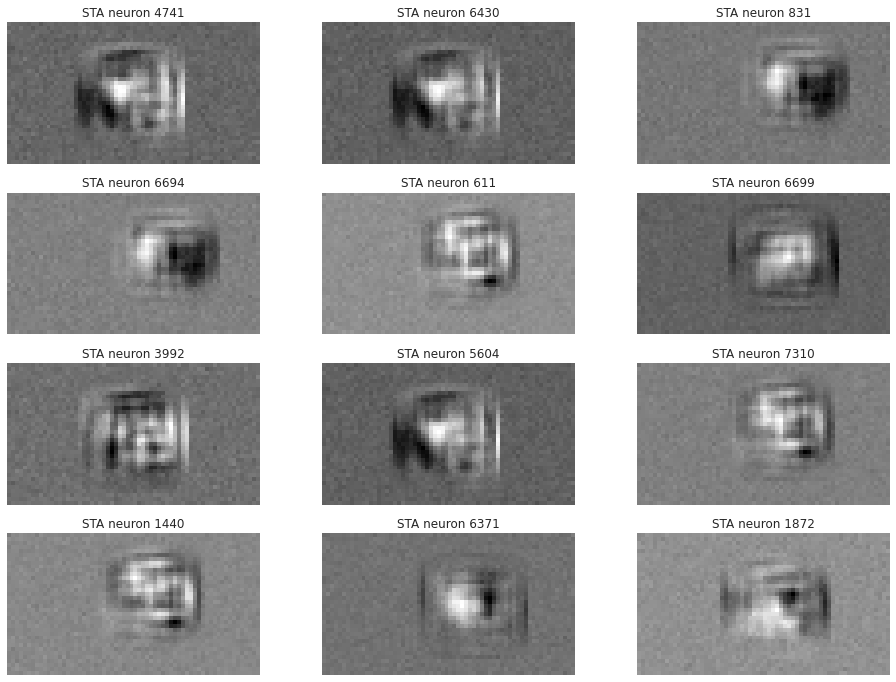

In [10]:
nlb.STA_model_sens(sensorium_model, 'models/sens_model.pt', best_neurons_sens)

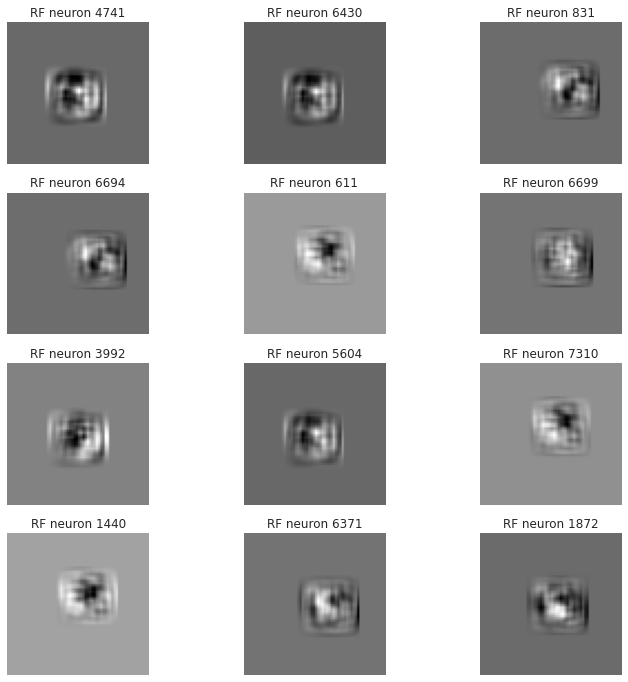

In [11]:
nlb.gradientRF(sensorium_model,'models/sens_model.pt',best_neurons_sens,device)

### For V1 and Postsub

/project/subiculum/code/Neural_Lib_Flo.py:922: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)


torch.Size([2500, 64, 64])
torch.Size([13, 2500])


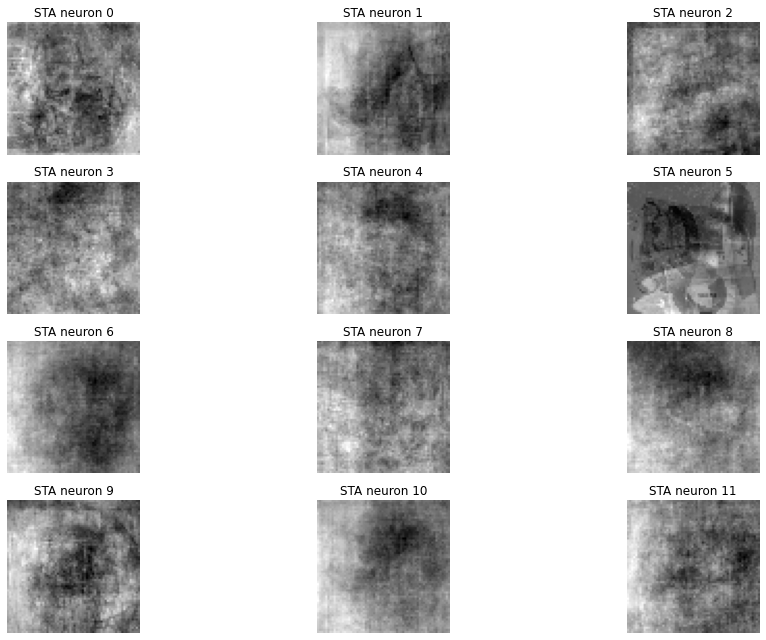

In [12]:
neurons_v1=[0,1,2,3,4,5,6,7,8,9,10,11,12]
nlb.sta_wo_model(device, neurons_v1 ,v1_responses_path, images_path,data_is_npy=False)

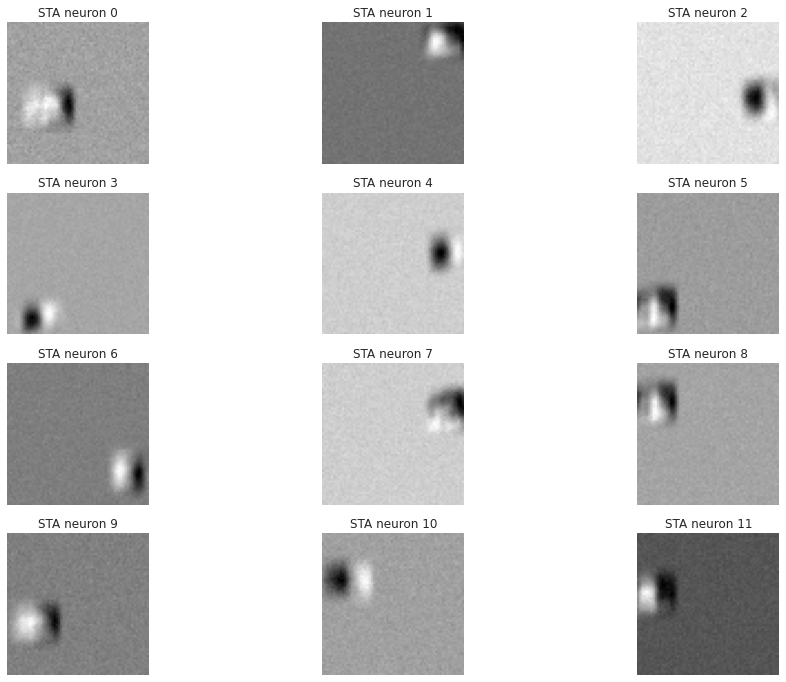

In [13]:
nlb.STA_model(v1_model, 'models/v1_model.pt', neurons_v1)

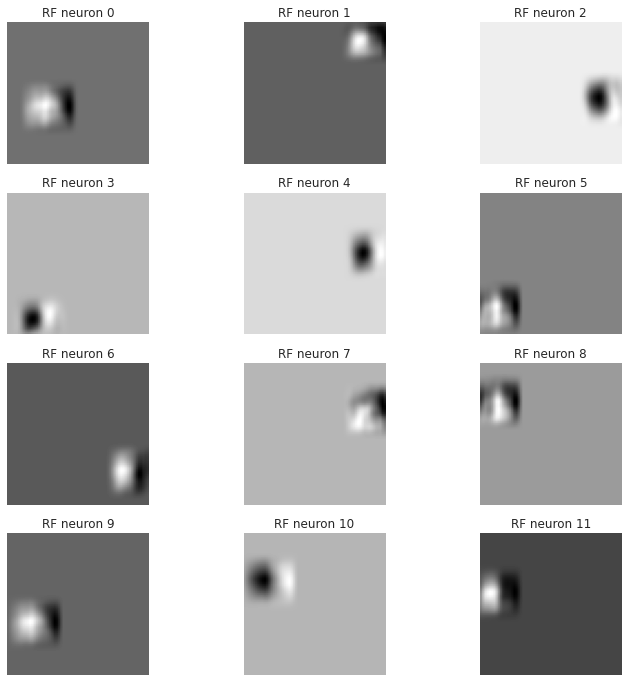

In [14]:
nlb.gradientRF(v1_model, 'models/v1_model.pt', neurons_v1,device)

torch.Size([2500, 64, 64])
torch.Size([13, 2500])


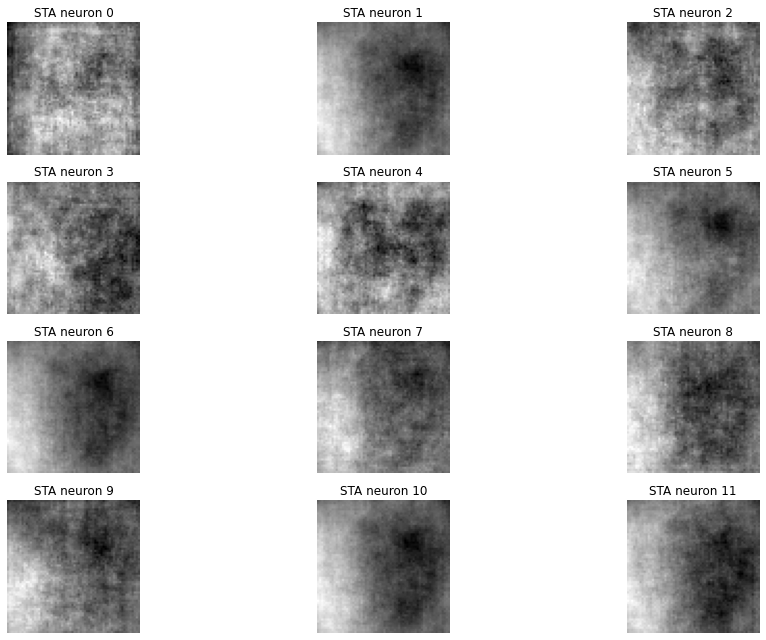

In [15]:
nlb.sta_wo_model(device, neurons_v1 ,v1_responses_path, images_path,data_is_npy=False, index_start=125,index_end=200)

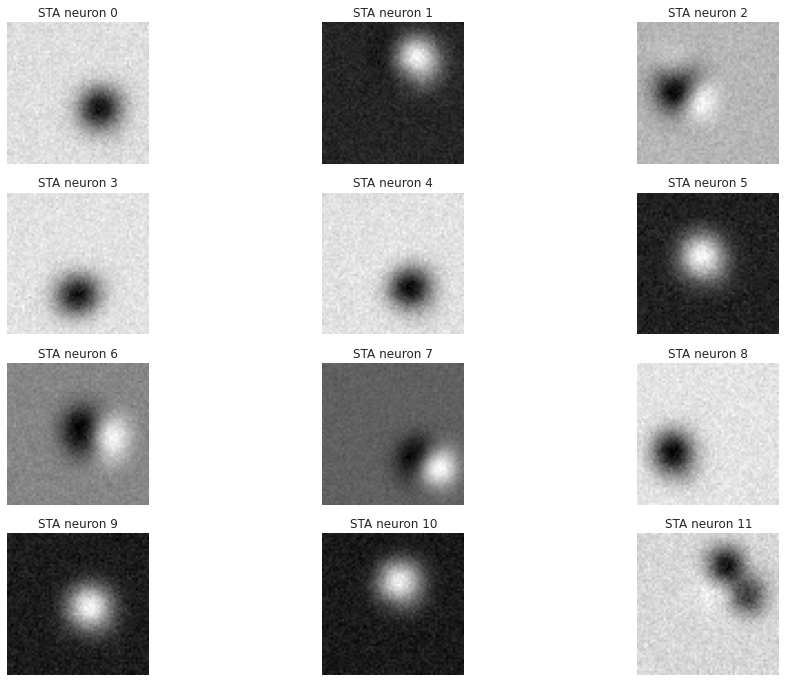

In [16]:
nlb.STA_model(v1_or_model, 'models/v1_model_or.pt', neurons_v1)

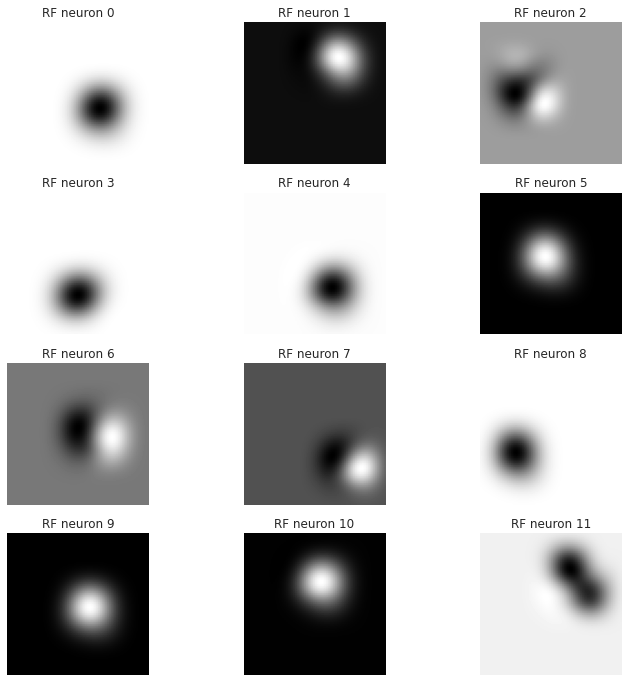

In [17]:
nlb.gradientRF(v1_or_model, 'models/v1_model_or.pt', neurons_v1,device)

torch.Size([2500, 64, 64])
torch.Size([37, 2500])


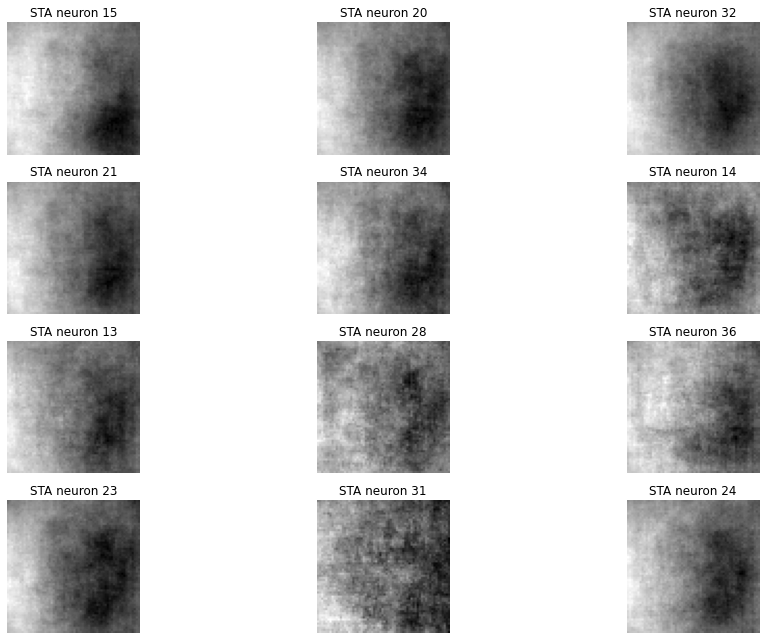

In [18]:
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
sub_model=nlb.configure_model(config, 37, device)
sub_state_dict=torch.load('models/sub_model.pt')
sub_model.load_state_dict(sub_state_dict)
with torch.no_grad():
    sub_val_corrs = nlb.get_correlations(sub_model, sub_val_loader, device)
best_neurons_sub = np.argsort(-sub_val_corrs)
nlb.sta_wo_model(device, best_neurons_sub ,sub_responses_path, images_path,data_is_npy=False)


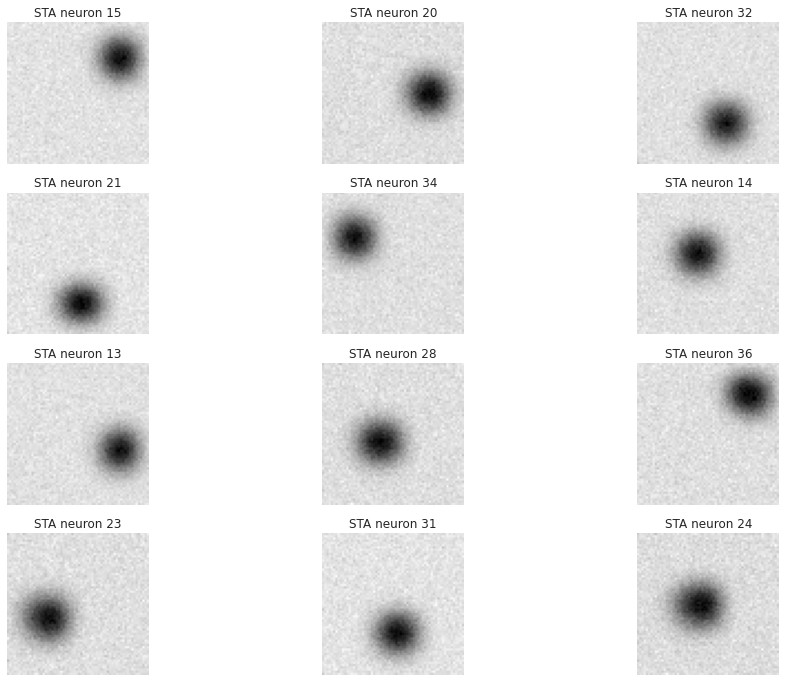

In [19]:
nlb.STA_model(sub_model, 'models/sub_model.pt', best_neurons_sub)

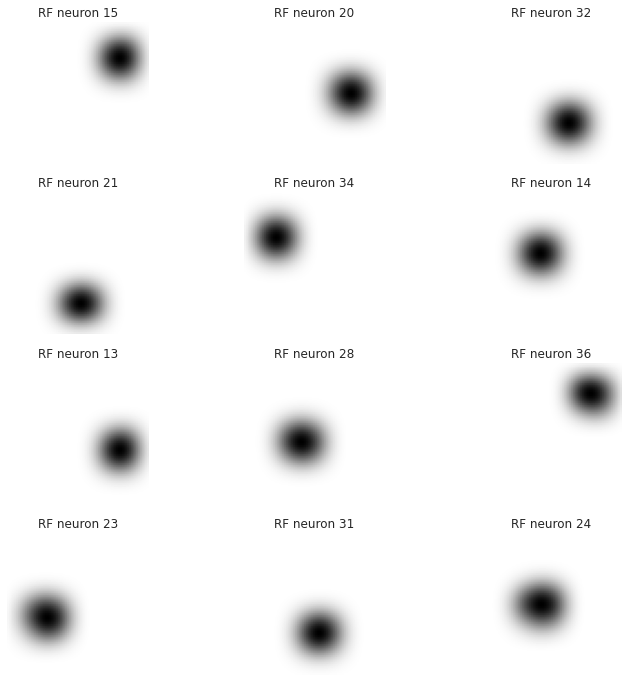

In [20]:
nlb.gradientRF(sub_model, 'models/sub_model.pt', best_neurons_sub,device)

For the off response the best predicted neurons in the postsub are different neurons, hence the different numbers!

In [21]:
with torch.no_grad():
    sub_val_corrs_or = nlb.get_correlations(sub_model_or, sub_val_loader_or, device)
best_neurons_sub_or = np.argsort(-sub_val_corrs_or)

torch.Size([2500, 64, 64])
torch.Size([37, 2500])


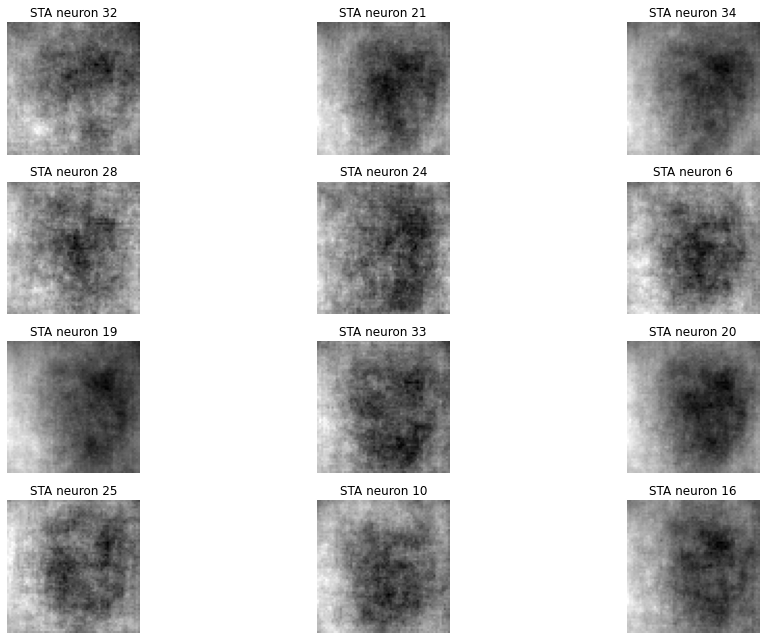

In [22]:
nlb.sta_wo_model(device, best_neurons_sub_or ,sub_responses_path, images_path,data_is_npy=False, index_start=125, index_end=200)

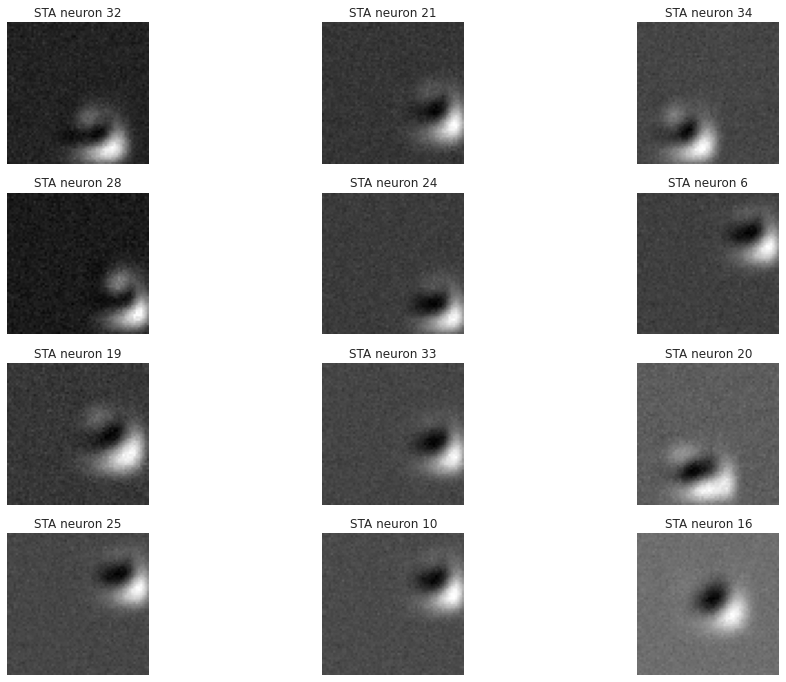

In [23]:
nlb.STA_model(sub_model_or, 'models/sub_model_or.pt', best_neurons_sub_or)

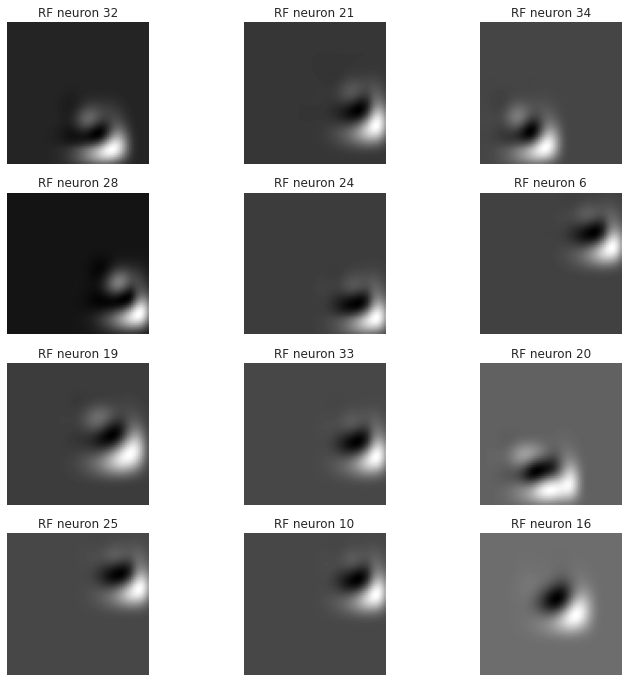

In [24]:
nlb.gradientRF(sub_model_or, 'models/sub_model_or.pt', best_neurons_sub_or,device)

## Changes to the model
1. Different readout
2. Depth separable convolutions

$\rightarrow$ compare the results, especially the position of the receptive fields to the predicitons of the basic model.

In [2]:
api = wandb.Api()
run = api.run("seifertflo/V1 Training 17-06-2024/2mr3hewa")
config=run.config
print(config.get("layers"))
v1_model_factorized = nlb.configure_model(config,13,device,False, reg_weight=0.5, fact_input=52)
print(v1_model_factorized)



3


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [ ]:
tl.training_and_eval_with_lr(v1_model_factorized,100,v1_train_loader, v1_test_loader, v1_val_loader, device,True,lr=1e-4,path_for_saving='models/v1_model_factorized.pt')

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 23.69 GiB total capacity; 1.05 GiB already allocated; 82.94 MiB free; 1.08 GiB reserved in total by PyTorch)

In [4]:
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
print(config.get("layers"))
sub_model_factorized=nlb.configure_model(config, 37, device, False, reg_weight=0.5, fact_input=40)
print(sub_model_factorized)
tl.training_and_eval_with_lr(sub_model_factorized,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_model_factorized.pt')

5
ConvModel(
  (conv_layers): Sequential()
  (core): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SiLU()
    (12): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU()
  )
  (re

NameError: name 'sub_train_loader' is not defined

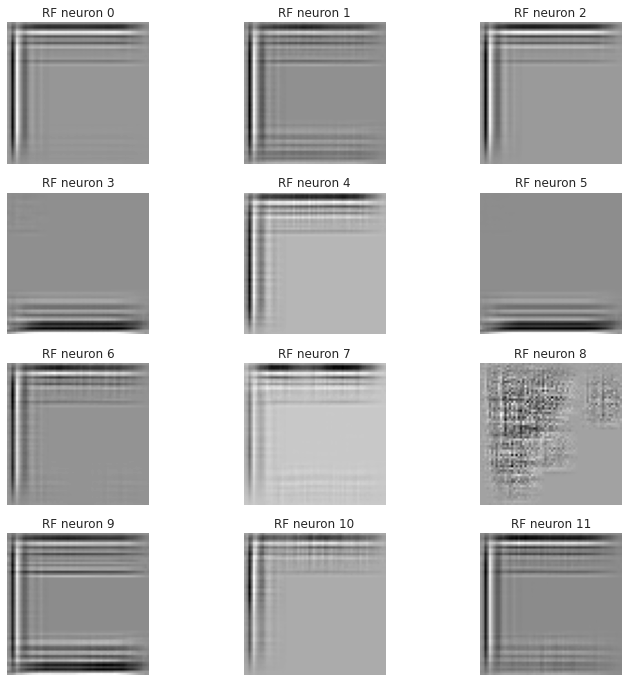

In [ ]:
nlb.gradientRF(v1_model_factorized, 'models/v1_model_factorized.pt', neurons_v1,device)

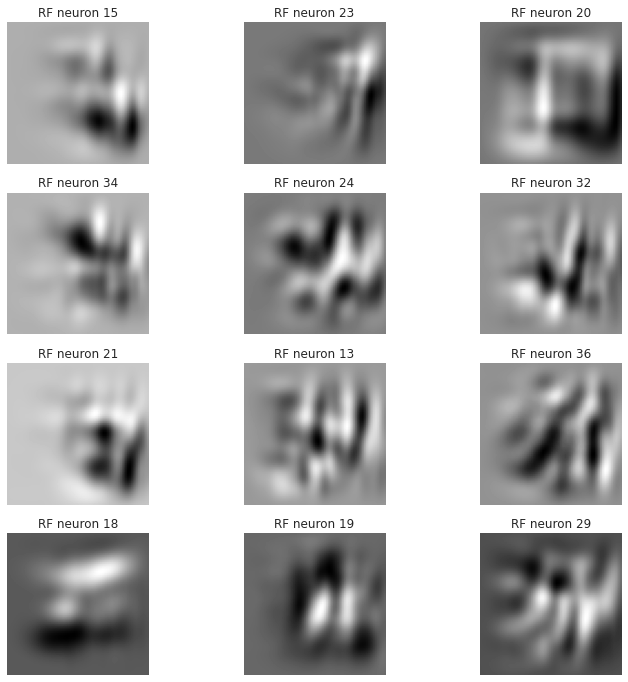

In [ ]:
nlb.gradientRF(sub_model_factorized, 'models/sub_model_factorized.pt', best_neurons_sub,device)


In [ ]:
sub_train_loader, sub_val_loader, sub_test_loader =nlb.dataloader_from_mat(images_path, sub_responses_path, 75, 125, 64)
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
print(config.get("layers"))
sub_ds_model_factorized=nlb.configure_depth_sep_model(config, 37, device, False, reg_weight=0.5, fact_input=40)
print(sub_ds_model_factorized)
tl.training_and_eval_with_lr(sub_ds_model_factorized,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_ds_model_factorized.pt')

5


/usr/local/lib/python3.8/dist-packages/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


DepthSepConvModel(
  (core): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU()
    (6): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2), groups=128)
      (poi

/usr/local/lib/python3.8/dist-packages/neuralpredictors/measures/modules.py:78: UserWarning: Poissonloss is averaged per batch. It's recommended to use `sum` instead
  warnings.warn("Poissonloss is averaged per batch. It's recommended to use `sum` instead")


Epoch [1/100], validation correlation: -0.0107, trainloss: 1.1799
Epoch [2/100], validation correlation: 0.0050, trainloss: 1.0479
Epoch [3/100], validation correlation: -0.0019, trainloss: 0.9892
Epoch [4/100], validation correlation: 0.0162, trainloss: 1.0657
Epoch [5/100], validation correlation: 0.0300, trainloss: 0.9162
Epoch [6/100], validation correlation: 0.0219, trainloss: 0.9909
Epoch [7/100], validation correlation: 0.0264, trainloss: 0.8411
Epoch [8/100], validation correlation: 0.0176, trainloss: 0.8519
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Epoch [9/100], validation correlation: 0.0049, trainloss: 0.8696
Epoch [10/100], validation correlation: 0.0244, trainloss: 0.8048
Early stopping triggered!

model saved as models/sub_ds_model_factorized.pt
Test Loss: 0.7867
Test Correlation: 0.0142


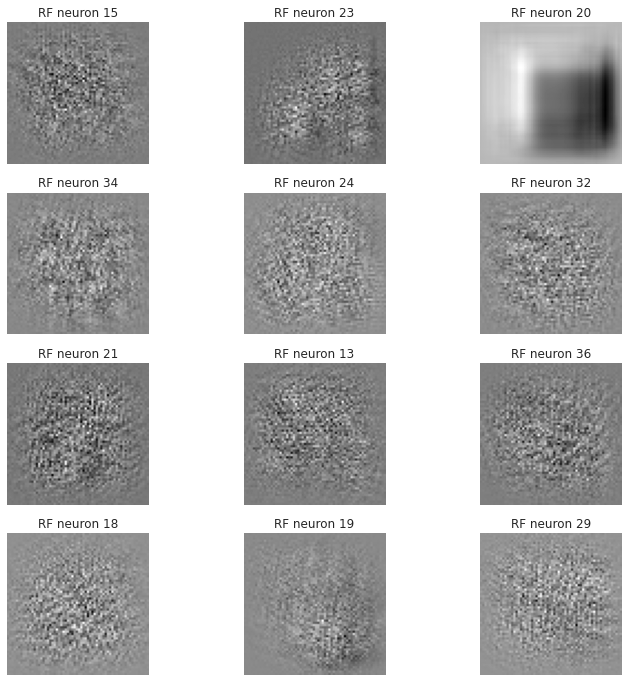

In [ ]:
best_neurons_sub=[15,23,20,34,24,32,21,13,36,18,19,29]
nlb.gradientRF(sub_ds_model_factorized, 'models/sub_ds_model_factorized.pt', best_neurons_sub,device)

In [ ]:
v1_train_loader, v1_val_loader, v1_test_loader = nlb.dataloader_from_mat(images_path, v1_responses_path, 75, 125, 64)

In [ ]:
api = wandb.Api()
run = api.run("seifertflo/Sub ON response Training 26-06-2024/wovxrvu7")
config=run.config
print(config.get("layers"))
sub_ds_model=nlb.configure_depth_sep_model(config, 37, device, reg_weight=0.5, fact_input=40)
print(sub_ds_model)
tl.training_and_eval_with_lr(sub_ds_model,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_ds_model.pt')

In [ ]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
api = wandb.Api()
run = api.run("seifertflo/Sub OFF response Training 24-06-2024/bp5jezif")
config=run.config
print(config.get("layers"))
sub_ds_model_factorized_or=nlb.configure_depth_sep_model(config, 37, device, False, reg_weight=0.5, fact_input=40)
print(sub_ds_model_factorized_or)
tl.training_and_eval_with_lr(sub_ds_model_factorized_or,100,sub_train_loader_or, sub_test_loader_or, sub_val_loader_or, device,True,lr=1e-4,path_for_saving='models/sub_ds_model_fact_or.pt')

In [ ]:
sub_train_loader_or, sub_val_loader_or, sub_test_loader_or =nlb.dataloader_from_mat(images_path, sub_responses_path, 125, 200, 64)
api = wandb.Api()
run = api.run("seifertflo/Sub OFF response Training 24-06-2024/bp5jezif")
config=run.config
print(config.get("layers"))
sub_ds_model_or=nlb.configure_depth_sep_model(config, 37, device, reg_weight=0.5, fact_input=40)
tl.training_and_eval_with_lr(sub_ds_model_factorized,100,sub_train_loader, sub_test_loader, sub_val_loader, device,True,lr=1e-4,path_for_saving='models/sub_ds_model_or.pt')

In [ ]:
nlb.gradientRF(sub_ds_model, 'models/sub_ds_model.pt', best_neurons_sub,device)

In [ ]:
nlb.gradientRF(sub_ds_model_factorized_or, 'models/sub_ds_model_fact_or.pt', best_neurons_sub,device)

In [ ]:
nlb.gradientRF(sub_ds_model_or, 'models/sub_ds_model_or.pt', best_neurons_sub,device)